# Abstractive Summarization
### Sequence to Sequence models with Attention

This project explores the problem of summarization using a sequence to sequence model. In a sequence to sequence problem there is an encoder and a decoder. In this example I feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We explore two architectures: Encoder-Decoder without an Attention layer and an Encoder-Decoder with custom Attention layer.

Note the source of the Attention layer is: http://www.cs.columbia.edu/~kathy/

 __References:__
1. *A Neural Attention Model for Abstractive Sentence Summarization* (Rush, et. al., 2015)
2. *Addressing the Rare Word Problem in Neural Machine Translation* (Sutskever†, et. al., 2014)
3. https://machinelearningmastery.com/encoder-decoder-models-text-summarization-keras/
4. http://pavel.surmenok.com/2016/10/15/how-to-run-text-summarization-with-tensorflow/

# Environment

__Built using:__
1. Keras 2.0.8
2. TensorFlow 1.4.0 GPU

__Trained using:__
1. Google Cloud Virtual Machine
2. 8 CPU | 5 GB Memory | 1 Tesla K80 GPU
3. Unbuntu 16+

# Data Preprocessing

__Note:__ The data for this project was proprietary and thus is not included in the repo. That said, to replicate results you can use news article summary pairs as obtained from the *Linguistic Data Consortium* (LDC)

First we prepare the data. Given training data in say train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. Note I limit the maximum vocabulary size to 20000 and maximum length of article based on the max article in training corpus. This requires padding of shorter articles and truncating others. 

In [1]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

from collections import Counter
import numpy as np
import re 

Using TensorFlow backend.


In [2]:
"""
The function load_data() reads in the data and truncates/pads according. 
Additionally it creates dictionaries out of both the articles and 
summaries which will be key to decoding the embedded predictions 
during the inference steps.
"""

def load_data(article, summary, vocab_size, max_len=None):
    raw_articles = []
    with open(article) as arts:
        counter = Counter()
        for line in arts:
            words = text_to_word_sequence(line)
            counter.update(words)
            raw_articles.append(words) 
        X_idx2word = [word[0] for word in counter.most_common(vocab_size)]
        X_idx2word.insert(0, 'ZERO')
        X_idx2word.append('UNK')
        X_vocab_len = len(X_idx2word)
        X_word2idx = {i:x for x,i in enumerate(X_idx2word)}
        if max_len is not None:
            X_max_len = max_len
        else:
            X_max_len = max([len(txt) for txt in raw_articles])
        defaultKey1 = X_word2idx.get('UNK')
        for lst in raw_articles:
            for idx, word in enumerate(lst):
                lst[idx] = X_word2idx.get(word, defaultKey1)
        transformed_articles = np.array(pad_sequences(raw_articles, value=0, maxlen=X_max_len))
        
    raw_summaries = []
    with open(summary) as sums:
        counter = Counter()
        for line in sums:
            words = text_to_word_sequence(line)
            counter.update(words)
            raw_summaries.append(words)
        y_idx2word = [word[0] for word in counter.most_common(vocab_size)]
        y_idx2word.insert(0, 'ZERO')
        y_idx2word.append('UNK')
        y_word2idx = {i:x for x,i in enumerate(y_idx2word)}
        y_vocab_len = len(y_word2idx)
        if max_len is not None:
            y_max_len = max_len
        else:
            y_max_len = max([len(txt) for txt in raw_summaries])
        defaultKey2 = y_word2idx.get('UNK')
        for lst in raw_summaries:
            for idx, word in enumerate(lst):
                lst[idx] = y_word2idx.get(word, defaultKey2)
        transformed_summaries = np.array(pad_sequences(raw_summaries, value=0, maxlen=y_max_len))

        
    return X_vocab_len, X_idx2word, X_word2idx, \
        y_vocab_len, y_idx2word, y_word2idx, \
        transformed_articles, transformed_summaries, X_max_len, y_max_len 
        


Now use the above function to load the training data from article and summary (i.e. title)

In [8]:
article = "data/train_article.txt"
summary = "data/train_title.txt" 
vocab_size = 20000

X_vocab_len, X_idx2word, X_word2idx, y_vocab_len, \
y_idx2word, y_word2idx, X_train_data, y_train_data, \
X_max_len, y_max_len = load_data(article, summary, vocab_size, max_len=20)


# Arichtecture 1: LSTM Encoder Decoder 

Define the parameters for your LSTM encoder decoder model. 

In [9]:
BATCH_SIZE = 500
NUM_LAYERS = 2
HIDDEN_DIM = 512
EPOCHS = 150

Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder.
Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [6]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, RepeatVector, TimeDistributed, Activation, Dropout, Bidirectional
from keras.models import Sequential

def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    
    model = Sequential()
    model.add(Embedding(X_vocab_len, hidden_size, input_length = X_max_len,  mask_zero=True))
    model.add(Bidirectional(LSTM(hidden_size, dropout=0.2, recurrent_dropout=0.3)))
    model.add(RepeatVector(y_max_len))
    for _ in range(num_layers):
        model.add(Bidirectional(LSTM(hidden_size, return_sequences=True, recurrent_dropout=0.2)))
    model.add(TimeDistributed(Dense(y_vocab_len)))
    model.add(Activation('softmax'))
        
    model.compile(loss='sparse_categorical_crossentropy', 
                      optimizer='Adam', 
                      metrics=['accuracy'])
    print(model.summary())
    return model

### Train the Model

Note training process below periodically saves the learned weights. The training process is very long even using GPU (see __settings__)

In [13]:
from time import time
from keras.callbacks import TensorBoard, ModelCheckpoint

model_plain = create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, HIDDEN_DIM, NUM_LAYERS)

tensorboard = TensorBoard(log_dir="data/logs/{}".format(time()))
filepath="data/weights/__weights-improvement-{epoch:02d}-{acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

print('Train...')
model_plain.fit(X_train_data,np.expand_dims(y_train_data, axis=-1),
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[tensorboard,checkpoint])

print('Saving model...')
model_plain.save_weights('data/weights/final_lstm_weights.h5')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 512)           10241024  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 20, 1024)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20, 1024)          6295552   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 20, 1024)          6295552   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 20002)         20502050  
_________________________________________________________________
activation_3 (Activation)    (None, 20, 20002)         0         
Total para

50000/50000 [==============================] - 223s - loss: 1.7439 - acc: 0.6922   
Epoch 53/150
50000/50000 [==============================] - 223s - loss: 1.7249 - acc: 0.6941   
Epoch 54/150
50000/50000 [==============================] - 224s - loss: 1.7091 - acc: 0.6955   
Epoch 55/150
50000/50000 [==============================] - 223s - loss: 1.6892 - acc: 0.6976   
Epoch 56/150
50000/50000 [==============================] - 223s - loss: 1.6717 - acc: 0.6994   
Epoch 57/150
50000/50000 [==============================] - 223s - loss: 1.6546 - acc: 0.7014   
Epoch 58/150
50000/50000 [==============================] - 223s - loss: 1.6384 - acc: 0.7029   
Epoch 59/150
50000/50000 [==============================] - 223s - loss: 1.6204 - acc: 0.7049   
Epoch 60/150
50000/50000 [==============================] - 223s - loss: 1.6151 - acc: 0.7053   
Epoch 61/150
50000/50000 [==============================] - 223s - loss: 1.5865 - acc: 0.7087   
Epoch 62/150
50000/50000 [=================

50000/50000 [==============================] - 221s - loss: 1.2938 - acc: 0.7463   
Epoch 81/150
50000/50000 [==============================] - 221s - loss: 1.2812 - acc: 0.7481   
Epoch 82/150
50000/50000 [==============================] - 222s - loss: 1.2687 - acc: 0.7497   
Epoch 83/150
50000/50000 [==============================] - 222s - loss: 1.2575 - acc: 0.7513   
Epoch 84/150
50000/50000 [==============================] - 222s - loss: 1.2430 - acc: 0.7534   
Epoch 85/150
50000/50000 [==============================] - 221s - loss: 1.2296 - acc: 0.7553   
Epoch 86/150
50000/50000 [==============================] - 221s - loss: 1.2172 - acc: 0.7571   
Epoch 87/150
50000/50000 [==============================] - 221s - loss: 1.2044 - acc: 0.7592   
Epoch 88/150
50000/50000 [==============================] - 221s - loss: 1.1927 - acc: 0.7605   
Epoch 89/150
50000/50000 [==============================] - 221s - loss: 1.1818 - acc: 0.7622   
Epoch 90/150
50000/50000 [=================

50000/50000 [==============================] - 221s - loss: 0.9608 - acc: 0.7975   
Epoch 109/150
50000/50000 [==============================] - 221s - loss: 0.9493 - acc: 0.7996   
Epoch 110/150
50000/50000 [==============================] - 221s - loss: 0.9383 - acc: 0.8015   
Epoch 111/150
50000/50000 [==============================] - 221s - loss: 0.9298 - acc: 0.8026   
Epoch 112/150
50000/50000 [==============================] - 221s - loss: 0.9184 - acc: 0.8047   
Epoch 113/150
50000/50000 [==============================] - 221s - loss: 0.9076 - acc: 0.8065   
Epoch 114/150
50000/50000 [==============================] - 221s - loss: 0.8961 - acc: 0.8087   
Epoch 115/150
50000/50000 [==============================] - 221s - loss: 0.8843 - acc: 0.8108   
Epoch 116/150
50000/50000 [==============================] - 221s - loss: 0.8735 - acc: 0.8127   
Epoch 117/150
50000/50000 [==============================] - 221s - loss: 0.8646 - acc: 0.8144   
Epoch 118/150
50000/50000 [=======

OSError: Driver write request failed (file write failed: time = Thu Dec 14 13:14:50 2017
, filename = 'data/weights/__weights-improvement-119-0.82.h5', file descriptor = 60, errno = 28, error message = 'No space left on device', buf = 0x7ffddaddddf0, total write size = 96, bytes this sub-write = 96, bytes actually written = 18446744073709551615, offset = 0)

In [ ]:
#model.save_weights('data/weights/lstm_weights.h5')
model_plain = create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, HIDDEN_DIM, NUM_LAYERS)
model_plain.load_weights('final_lstm_model_111217.h5')

## Evaluation using Rouge score 

Now that we have the trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process the test data in the same way as the train data above, then use the trained model to predict on the test titles. 

To evalute out model performance in a seq2seq model we use Blue or Rouge score. Here we use the Rouge score. A Python package to aid in this can be obtained from: https://pypi.python.org/pypi/rouge/0.2.1

In [3]:
from rouge import Rouge
import os.path


def to_strings(data):
    return data.split('\n')

def load_file(file):
    f = open(file, 'r')
    data = f.read()
    f.close()
    return data

def save_file(data):
    _dir = 'data/'
    fileName = os.path.join(_dir, 'data/test_results.txt') 
    f = open(fileName, 'w')
    f.write(data)
    f.close()
    return None

def load_test_data(file, X_word2idx, X_max_len):
    X_data = load_file(file)
    X = [text_to_word_sequence(x) for x in X_data.split('\n')]
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            if word in X_word2idx:
                X[i][j] = X_word2idx[word]
            else:
                X[i][j] = X_word2idx['UNK']
    return pad_sequences(X, maxlen=X_max_len, dtype='int32')

def make_predictions(model, X_test, y_idx2word, save=False, print_results=False, prnt_num=15):
    predictions = np.argmax(model.predict(X_test), axis=2)
    sequences = []
    for prediction in predictions:
        sequence = ' '.join([y_idx2word[index] for index in prediction if index > 0])
        sequences.append(sequence)
    if save:
        np.savetxt('data/test_results.txt', sequences, fmt='%s')
    if print_results:
        for seq in sequences[:prnt_num]:
            print(seq)
    return sequences

def get_rouge_scores(preds, hyps, avg=True):
    if len(hyps) != len(preds):
            p_len = len(preds)
            hyps = hyps[:p_len]  
    rouge = Rouge()
    print("Calculating rouge scores...")
    scores = rouge.get_scores(hyps, preds, avg=avg)
    return scores



In [14]:
test_articles = "data/test_article.txt"
ref_file = "data/test_results.txt"
hyp_file = "data/test_title.txt"

hyps = to_strings(load_file(hyp_file))
X_test = load_test_data(test_articles, X_word2idx, X_max_len)

preds2 = make_predictions(model_plain, X_test, y_idx2word, print_results=True, prnt_num=5)
get_rouge_scores(hyps, preds2, avg=True)


The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
london share prices higher at midday
london share share prices lower at midday
felipe felipe to to to for for for title
moves as play to to kaiserslautern final
a s s s years after a a started on a started
Calculating rouge scores...


{'rouge-1': {'f': 0.15478922572549195,
  'p': 0.18669590182231235,
  'r': 0.13909750047164957},
 'rouge-2': {'f': 0.04903181149019227,
  'p': 0.051577181408634057,
  'r': 0.048045540494833457},
 'rouge-l': {'f': 0.13250889169904742,
  'p': 0.14419579412794667,
  'r': 0.13576955350418271}}

In [ ]:
#model.save_weights('data/weights/lstm_weights.h5')
model_plain = create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, HIDDEN_DIM, NUM_LAYERS)
model_plain.load_weights('data/weights/__weights-improvement-99-0.78.h5')

The summaries are quite poor despite on par rouge scores. In encoder decoder architecture, only the final state of encoder is used to calculate the probabilities which leads to sub-optimal results.

## Tensorboard Visualization 

We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online). 

Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

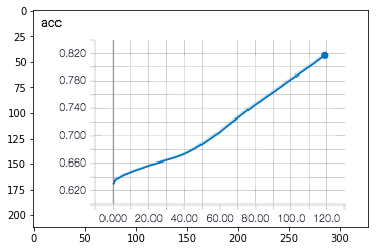

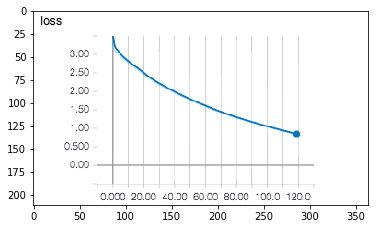

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('images/acc.png')
plt.imshow(image)
plt.show()
image2 = mpimg.imread('images/loss.png')
plt.imshow(image2)
plt.show()

# Architecture 2: LSTM Encoder Decoder With Attention 

In [16]:
BATCH_SIZE = 300 
HIDDEN_DIM = 128 
EPOCHS = 100

Now we turn to an Attention architecture. Attention models use a weighted sum of all weights of encoder instead of just the last one (__see references__). In the code below, if return_probabilities is false, the attention decoder returns the prediction model; when true, the probability model is returned. Both models are needed in the inference and visualization sections.

In [276]:
article = "data/train_article.txt"
summary = "data/train_title.txt" 
vocab_size = 10000 # Not training time consideration vocab_size is reduced

X_vocab_len, X_idx2word, X_word2idx, y_vocab_len, \
y_idx2word, y_word2idx, X_train_data, y_train_data, \
X_max_len, y_max_len = load_data(article, summary, vocab_size, max_len=20)

In [17]:
from keras.models import Model,Sequential
from keras.layers import Input, LSTM, Dense, Embedding, RepeatVector, TimeDistributed, Activation, Dropout, Bidirectional
from attention_decoder import AttentionDecoder
from time import time

def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, return_probabilities = False):
    # create and return the model for unidirectional LSTM encoder decoder with attention
    model = Sequential()
    model.add(Embedding(X_vocab_len, hidden_size, input_length = X_max_len,  mask_zero=True))
    model.add(LSTM(hidden_size, dropout=0.2, recurrent_dropout=0.1, return_sequences=True))
    model.add(AttentionDecoder(hidden_size, y_vocab_len,return_probabilities=return_probabilities))

    start = time()    
    model.compile(loss='sparse_categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=['accuracy'])
    end = time()
    print("Time to compile: {}".format(end-start))
    print()
    print(model.summary())
    return model

## Train the Model

In [18]:
from keras.callbacks import TensorBoard, ModelCheckpoint

model = create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, HIDDEN_DIM)

tensorboard = TensorBoard(log_dir="data/logs/{}_{}".format("attn",time()))
filepath="data/weights/attn_weights-improvement-{epoch:02d}-{acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max', period=10)


print('Train...')
model.fit(X_train_data,np.expand_dims(y_train_data, axis=-1),
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          shuffle=True,
          callbacks=[checkpoint])



Time to compile: 0.06444859504699707

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 128)           1280256   
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 20, 10002)         106599382 
Total params: 108,011,222
Trainable params: 108,011,222
Non-trainable params: 0
_________________________________________________________________
None
Train...
Epoch 1/100
50000/50000 [==============================] - 448s - loss: 4.5684 - acc: 0.4785   
Epoch 2/100
50000/50000 [==============================] - 441s - loss: 4.0567 - acc: 0.4929   
Epoch 3/100
50000/50000 [==============================] - 441s - loss: 3.9375 - acc: 0.4983   
Epoch 4/100
50000/50000 [===========================

50000/50000 [==============================] - 439s - loss: 2.3159 - acc: 0.5673   
Epoch 66/100
50000/50000 [==============================] - 439s - loss: 2.3046 - acc: 0.5683   
Epoch 67/100
50000/50000 [==============================] - 439s - loss: 2.2949 - acc: 0.5689   
Epoch 68/100
50000/50000 [==============================] - 439s - loss: 2.2819 - acc: 0.5695   
Epoch 69/100
50000/50000 [==============================] - 439s - loss: 2.2700 - acc: 0.5708   
Epoch 70/100
50000/50000 [==============================] - 440s - loss: 2.2602 - acc: 0.5712   
Epoch 71/100
50000/50000 [==============================] - 439s - loss: 2.2515 - acc: 0.5718   
Epoch 72/100
50000/50000 [==============================] - 439s - loss: 2.2373 - acc: 0.5734   
Epoch 73/100
50000/50000 [==============================] - 439s - loss: 2.2281 - acc: 0.5732   
Epoch 74/100
50000/50000 [==============================] - 439s - loss: 2.2172 - acc: 0.5744   
Epoch 75/100
50000/50000 [=================

KeyboardInterrupt: 

In [20]:
print('Saving model...')
model.save_weights('data/weights/good_Attn_weights.h5')

Saving model...


## Evaluation using Rouge Score

Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

In [277]:
test_articles = "data/test_article.txt"
ref_file = "data/test_results.txt"
hyp_file = "data/test_title.txt"

hyps = to_strings(load_file(hyp_file))
X_test = load_test_data(test_articles, X_word2idx, X_max_len)
preds = make_predictions(model, X_test, y_idx2word, print_results=True, prnt_num=5)
get_rouge_scores(hyps, preds, avg=True)


london london london london london share prices up at midday
london london london london london share prices lower at midday
liverpool liverpool liverpool says says he he to to to for to UNK
struggle UNK namibia namibia matches world cup
open open UNK open open open u s open
Calculating rouge scores...


{'rouge-1': {'f': 0.20578345893533173,
  'p': 0.29359017563559769,
  'r': 0.17406977971658136},
 'rouge-2': {'f': 0.049910955217185596,
  'p': 0.047189525467628592,
  'r': 0.056722237117894876},
 'rouge-l': {'f': 0.13866889437197633,
  'p': 0.13766678406236199,
  'r': 0.16692172742941139}}

## Analysis

Below we visualize the attention weights for a sentence and output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. Note the analysis is fairly difficult given several issues such as repeating words, etc that are inherent to abstractive summarization with seq2seq models.

In [33]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [150]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
        
        
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        
        # get the output sequence
        prediction = np.argmax(self.pred_model.predict(padded_data_vec), axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[
            0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        #i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        i = ax.imshow(np.log(activation_map), interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()
        #f.savefig('filename') 

In [151]:
viz = Visualizer()

In [25]:
prob_model = create_UniLSTMwithAttention(X_vocab_len,X_max_len,y_vocab_len,y_max_len,HIDDEN_DIM,return_probabilities=True)
prob_model.load_weights('data/weights/good_Attn_weights.h5')

Time to compile: 0.05495190620422363

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 128)           1280256   
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 20, 20)            106599382 
Total params: 108,011,222
Trainable params: 108,011,222
Non-trainable params: 0
_________________________________________________________________
None


In [152]:
viz.set_models(model,prob_model)

In [29]:
test_articles = "data/test_article.txt"
hyp_file = "data/test_title.txt"

hyps = to_strings(load_file(hyp_file))
X_test = load_test_data(test_articles, X_word2idx, X_max_len)

In [135]:
def viz_samples(lst, text, test_data_vector, y_idx2word):
    for i in lst:
        test_data_vector = np.reshape(X_test[i],(1,20))
        viz.attention_map(text[i], test_data_vector, y_idx2word)

## Examples

__Analysis:__
The first two examples show semantic correctness in addition to good levels of abstractive summarization such as in example 2. In example 3 relating to Pakistan the model appears to be doing more extractive summarization as opposed to abstractive summarization which led to a good result. Furthermore in example 3 the words of meaningful importance have higher weights relative to less important as you'd expect such as "loan" and "valencia". Repeat words are clearly an issue with the model and in later sections we see the repeat words often take the place for unknown words in the gold summary. Typically when the model has several repeat words we can also note an issue with compressing where the prediction is longer than the gold standard. Example 2 is quite interesting because the model is almost entirely performing abstrative summarization and while it does not match the gold standard 100% the model captures the crux of the meaning of the sentence. 


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


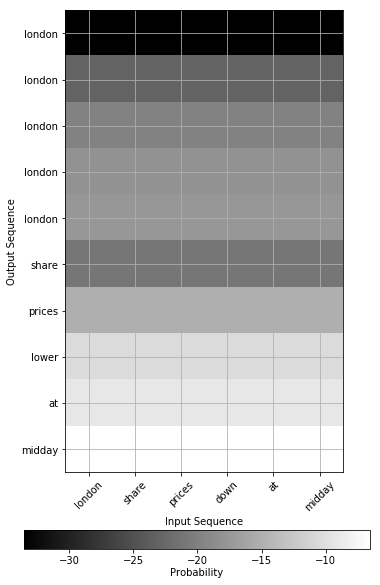

In [153]:
viz.attention_map(hyps[1], np.reshape(X_test[1],(1,20)), y_idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


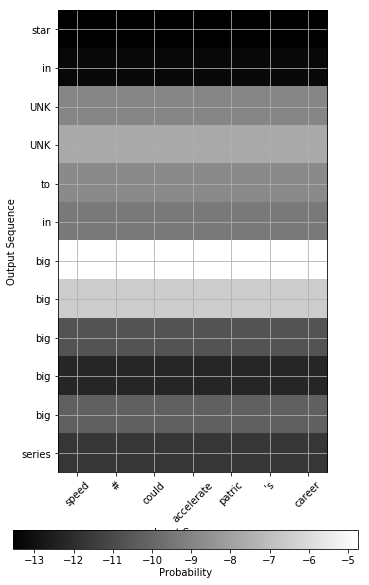

In [159]:
viz.attention_map(hyps[702], np.reshape(X_test[702],(1,20)), y_idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


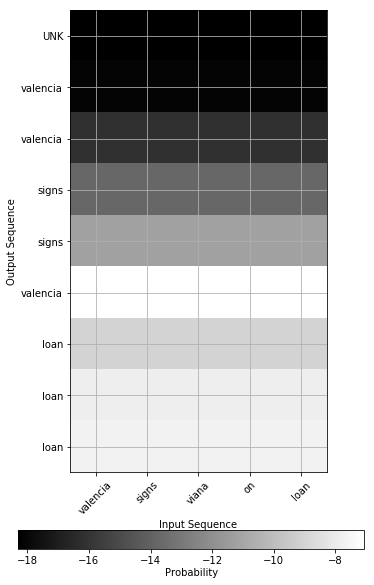

In [165]:
viz.attention_map(hyps[61], np.reshape(X_test[61],(1,20)), y_idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


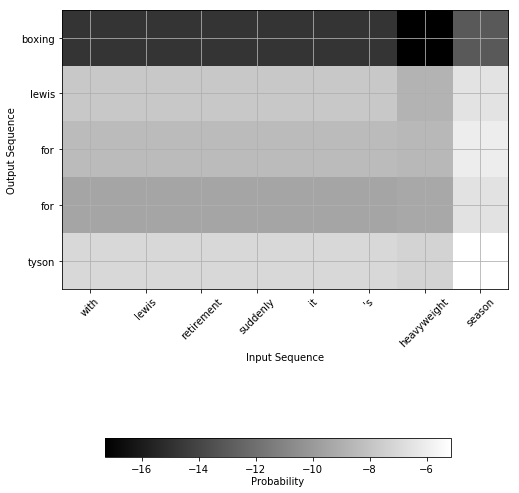

In [191]:
viz.attention_map(hyps[63], np.reshape(X_test[63],(1,20)), y_idx2word)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


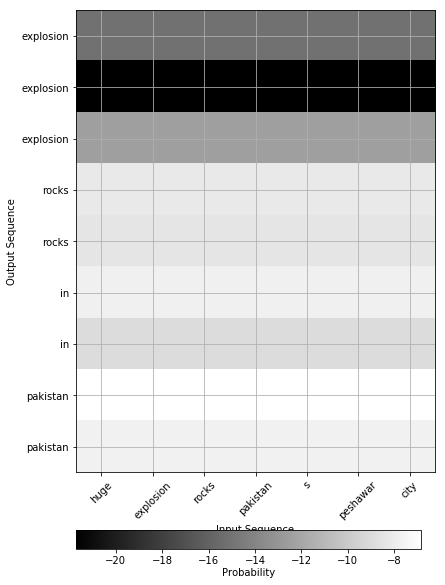

In [195]:
viz.attention_map(hyps[99], np.reshape(X_test[99],(1,20)), y_idx2word)

__Analysis:__
In the random examples I chose a few where I thought the model was both good and bad. On a positive note the model at times does a good job capturing the main subject of the article as in example 4 below where it captures Boeing as the main subject. This is supported in that the weights for film and festive are of high importance. On a negative note the model clearly suffers from attachment issues as in example 2,3, and 5 where it captures for instance that the article is about the film festivial but it entirely fails to capture the subject Pixar. The weights in example 5 is a great example of the difficultly the model has with pronouns like names - assigning high weigh to them but classifying them as unknown. Repeat words are again an issue.


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


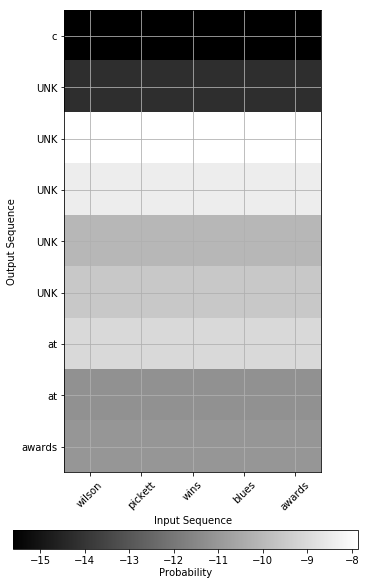

In [162]:
viz.attention_map(hyps[46], np.reshape(X_test[46],(1,20)), y_idx2word)

In [294]:
i = 819
attn = make_predictions(model, X_test[i].reshape(1,20), y_idx2word, save=False, print_results=False, prnt_num=1)
Inp = to_strings(load_file(test_articles))

print("Input:", Inp[i])
print("Gold:", hyps[i])
print("Plain:", pred2[i])
print("Attn:", attn[0])

Input: the greatest day of the l.a. college football season was n't a saturday .
Gold: best day for l.a. football is sunday
Attn: football football college college college college of the players


## Table of Examples

__Input(1):__ share prices on the london stock exchange were lower at midday thursday.<br />
__Gold:__ london share prices down at midday <br />
__Plain:__ london share share prices lower at midday<br />
__Attn:__ london london london london london share prices lower at midday<br />
<br />
__Input(2):__ jason patric did n't take hollywood 's big-budget blockbuster star trip .<br /> 
__Gold:__ speed # could accelerate patric 's career <br />
__Plain:__ tom 's 's and has has is talking a exaggerated<br />
__Attn:__ star in UNK UNK to in big big big big big series<br />
<br />
__Input(3):__ valencia has signed newcastle midfielder hugo viana on a season 's loan.<br />
__Gold:__ valencia signs viana on loan <br />
__Plain:__ valencia signs unk unk on on on deal <br />
__Attn:__ UNK valencia valencia signs signs valencia loan loan loan <br />
<br />
__Input(4):__ with lennox lewis gone , it 's suddenly a good time to be a heavyweight . <br />
__Gold:__ with lewis retirement suddenly it 's heavyweight season <br />
__Plain:__ it 's n't n't be sanchez knows be for for his time <br />
__Attn:__ boxing lewis for for Tyson <br />
<br />
__Input(5):__ a huge explosion has rocked pakistan 's main northwest city of peshawar .<br /> 
__Gold:__ huge explosion rocks pakistan s peshawar city <br />
__Plain:__ hits hits new air wave s s s city <br />
__Attn:__ explosion explosion explosion rocks rocks in in pakistan pakistan <br />